In [1]:
import random
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR

In [2]:
TRAIN_CSV = "/kaggle/input/sel-dataset/train_split.csv"
TEST_CSV  = "/kaggle/input/sel-dataset/test_split.csv"

SELECTED_SENSORS = [
    'A_x [g]_x', 'A_y [g]_x', 'A_z [g]_x',
    'A_x [g]_y', 'A_y [g]_y', 'A_z [g]_y',
    'M_x [gauss]', 'M_y [gauss]', 'M_z [gauss]',
    'G_x [mdps]', 'G_y [mdps]', 'G_z [mdps]',
    'PRESS', 'TEMP'
]
WINDOW_SIZE = 600
BATCH_SIZE = 32
SAMPLING_FREQ = 200
ADD_FEATS = False
BATTERY_LOW_THRESHOLD = 0.20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SensorDataset(Dataset):
    def __init__(self, windows, io_labels, scene_labels, scaler, io_encoder, scene_encoder, is_train=False):
        self.scaler = scaler
        self.io_label_encoder = io_encoder
        self.scene_label_encoder = scene_encoder
              
        windows_reshaped = windows.reshape(len(windows), -1)
        
        if is_train:
            # if training set, FIT and transform
            windows_scaled = self.scaler.fit_transform(windows_reshaped)
            self.io_labels = self.io_label_encoder.fit_transform(io_labels)
            self.scene_labels = self.scene_label_encoder.fit_transform(scene_labels)
        else:
            # otherwise, just transform
            windows_scaled = self.scaler.transform(windows_reshaped)
            self.io_labels = self.io_label_encoder.transform(io_labels)
            self.scene_labels = self.scene_label_encoder.transform(scene_labels)
            
        self.windows = windows_scaled.reshape(windows.shape)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        tensor_data = torch.FloatTensor(self.windows[idx])
        return (tensor_data.permute(1, 0), 
                torch.LongTensor([self.io_labels[idx]]),
                torch.LongTensor([self.scene_labels[idx]]))

In [4]:
full_train_df = pd.read_csv(TRAIN_CSV)
test_df_original = pd.read_csv(TEST_CSV)
master_df = pd.concat([full_train_df, test_df_original], ignore_index=True)

# extract all windows from the full dataset
def create_all_windows(data, window_size, sensors):
    windows = []
    io_labels = []
    scene_labels = []
    step_size = window_size // 2

    for i in range(0, len(data) - window_size, step_size):
        window_df = data.iloc[i:i + window_size]
        io_unique = window_df['I/O Detection'].unique()
        scene_unique = window_df['Scene Identification'].unique()
        
        if len(io_unique) == 1 and len(scene_unique) == 1:
            windows.append(window_df[sensors].values)
            io_labels.append(io_unique[0])
            scene_labels.append(scene_unique[0])
            
    return np.array(windows), np.array(io_labels), np.array(scene_labels)

all_windows, all_io_labels, all_scene_labels = create_all_windows(master_df, WINDOW_SIZE, SELECTED_SENSORS)

print(f"Totale finestre valide create: {len(all_windows)}")

# stratify on scene labels to have a good balance
train_windows, val_test_windows, train_io, val_test_io, train_scene, val_test_scene = train_test_split(
    all_windows, all_io_labels, all_scene_labels,
    test_size=0.3,
    random_state=42,
    stratify=all_scene_labels
)

val_windows, test_windows, val_io, test_io, val_scene, test_scene = train_test_split(
    val_test_windows, val_test_io, val_test_scene,
    test_size=0.5,
    random_state=42,
    stratify=val_test_scene
)

print(f"Finestre di Training: {len(train_windows)}")
print(f"Finestre di Validazione: {len(val_windows)}")
print(f"Finestre di Test: {len(test_windows)}")

scaler = StandardScaler()
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

train_ds = SensorDataset(train_windows, train_io, train_scene, scaler, io_encoder, scene_encoder, is_train=True)
validation_ds = SensorDataset(val_windows, val_io, val_scene, scaler, io_encoder, scene_encoder, is_train=False)
test_ds = SensorDataset(test_windows, test_io, test_scene, scaler, io_encoder, scene_encoder, is_train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, drop_last=True)

print("\nDataLoaders creati con successo usando il metodo ibrido.")

Totale finestre valide create: 16034
Finestre di Training: 11223
Finestre di Validazione: 2405
Finestre di Test: 2406

DataLoaders creati con successo usando il metodo ibrido.


In [5]:
# Depthwise sep 1D conv
def depthwise_separable_conv1d(in_ch, out_ch, kernel_size, stride=1, padding=0, drop_p=0.3):
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv1d(in_channels=in_ch, out_channels=in_ch,
                  kernel_size=kernel_size, stride=stride,
                  padding=padding, groups=in_ch, bias=False),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(),
        # Pointwise convolution
        nn.Conv1d(in_channels=in_ch, out_channels=out_ch,
                  kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm1d(out_ch),
        nn.ReLU()
    )

class DepthwiseEarlyExitCNN1D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene):
        super().__init__()
        self.if_train = if_train
        seq_len, n_sensors = train_shape
        
        # thresholds
        self.base_logit0 = nn.Parameter(torch.tensor(0.0, device=device))
        self.delta_logit0 = nn.Parameter(torch.tensor(1.0, device=device))
        self.base_logit1 = nn.Parameter(torch.tensor(0.0, device=device))
        self.delta_logit1 = nn.Parameter(torch.tensor(1.0, device=device))
        self.softplus = nn.Softplus()

        # ---- 1D backbone with separable convs ----
        self.backbone = nn.ModuleList([
            nn.Sequential(
                depthwise_separable_conv1d(n_sensors, 8, kernel_size=6, stride=3, padding=2),
                depthwise_separable_conv1d(8, 16, kernel_size=5, stride=2, padding=2) # Added block
            ),
            depthwise_separable_conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            # NEW: additional conv block before exit3
            nn.Sequential(
                depthwise_separable_conv1d(32, 48, kernel_size=3, stride=1, padding=1),
                depthwise_separable_conv1d(48, 64, kernel_size=3, stride=1, padding=1)
            )
            # depthwise_separable_conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        ])

        # ---- exit heads ----
        self.exits = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(16, n_io)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(32, n_scene)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(64, n_scene)
            ),
        ])

        # ---- adapters for fusion ----
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io, n_scene), # out0 -> exit1
            nn.Linear(n_scene, n_scene), # exit1 self
            nn.Linear(n_io, n_scene), # out0 -> exit2
            nn.Linear(n_scene, n_scene), # exit1 -> exit2
            nn.Linear(n_scene, n_scene), # exit2 self
        ])

    def compute_thr(self, base_logit, delta_logit):
        # base ∈(0,1), delta>0 ⇒ thr_acc = base+delta clamped su [0,1]
        base  = torch.sigmoid(base_logit)
        delta = self.softplus(delta_logit)
        return torch.clamp(base + delta, 0.0, 1.0)

    def map_battery(self, battery_level):
        # Sigmoide steep per dare più sensibilità intorno a 50%
        # battery_level può essere float o Tensor
        x = battery_level - 0.5
        return torch.sigmoid(x * 10.0)
    
    def exit_confidence_based(self, logits, thr, mode='all'):
        """
        Ritorna un bool Python:
          - mode='all': True se TUTTE le confidenze ≥ thr
          - mode='any': True se ALMENO UNA confidenza ≥ thr
        """
        # logits: [batch, n_classes]
        confs = F.softmax(logits, dim=-1).max(dim=-1).values   # [batch]
        if mode == 'all':
            return bool((confs >= thr).all().item())
        else:
            return bool((confs >= thr).any().item())

    def get_confidence(self, logits):
        return F.softmax(logits, dim=-1).max(dim=-1)[0]

    def forward(self, x, battery_level=1.0):
        x = x.permute(0, 2, 1)
        
        # exit0
        thr0_acc = self.compute_thr(self.base_logit0, self.delta_logit0)
        thr0_eff = torch.sigmoid(self.base_logit0)
        alpha0 = self.map_battery(battery_level)
        current_thr0 = thr0_eff + (thr0_acc - thr0_eff) * alpha0

        # exit1
        thr1_acc = self.compute_thr(self.base_logit1, self.delta_logit1)
        thr1_eff = torch.sigmoid(self.base_logit1)
        alpha1 = self.map_battery(battery_level)
        current_thr1 = thr1_eff + (thr1_acc - thr1_eff) * alpha1
        
        # Se if_train è True, esegui la logica di training originale
        if self.if_train:
            res = []
            out0, out1, out2 = None, None, None
            
            for i, (block, exit_head) in enumerate(zip(self.backbone, self.exits)):
                x = block(x)
                out_raw = exit_head(x)
                if i == 0:
                    out0 = out_raw
                    res.append(out0)
                elif i == 1:
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out_raw)
                    res.append(out1)
                else:
                    out2 = (
                        self.ensemble[2](out0.detach()) +
                        self.ensemble[3](res[1].detach()) +
                        self.ensemble[4](out_raw)
                    )
                    res.append(out2)
            
            # probabilità di exit basate sulle soglie dinamiche
            conf0 = self.get_confidence(out0)
            conf1 = self.get_confidence(out1)
            p_exit0 = (conf0 <  current_thr0).float()
            p_exit1 = (conf0 >= current_thr0) * (conf1 <  current_thr1).float()
            p_exit2 = (conf0 >= current_thr0) * (conf1 >= current_thr1).float()
            p_exits = torch.stack([p_exit0, p_exit1, p_exit2], dim=1)
            
            return res, p_exits

        x0 = self.backbone[0](x)        # → [1, F0, T0]
        out0 = self.exits[0](x0)          # → [1, n_io]
        conf0 = self.get_confidence(out0)  # → [1]
        if battery_level.item() <= BATTERY_LOW_THRESHOLD or conf0.item() > current_thr0.item():
            return [out0], 1
            
        # Step 3: Calcola la Scene Detection (Exit 1)
        x1 = self.backbone[1](x0)
        out1_raw = self.exits[1](x1)
        out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](out1_raw)
        conf1 = self.get_confidence(out1)

        if conf1.item() > current_thr1.item():
            return [out0, out1], 2

        # Step 4: Calcola la Scene Detection finale (Exit 2)
        x2 = self.backbone[2](x1)
        out2_raw = self.exits[2](x2)
        out2 = (
            self.ensemble[2](out0.detach()) +
            self.ensemble[3](out1.detach()) +
            self.ensemble[4](out2_raw)
        )
        return [out0, out1, out2], 3

In [6]:
def run_epoch(model, loader, criterion, optimizer, scheduler, train, lambda_cost=0.01, battery_sampler=None):
    model.if_train = True
    model.train() if train else model.eval()

    # Contatori per le metriche
    total_loss = 0.0
    total_cls_loss = 0.0 # Per monitorare la loss di classificazione
    total_cost_loss = 0.0 # Per monitorare la loss di costo
    total_samples = 0
    correct_io, total_io = 0, 0
    correct_sc1, total_sc1 = 0, 0
    correct_sc2, total_sc2 = 0, 0
    
    # Costi computazionali relativi per ogni uscita
    exit_costs = torch.tensor([0.3, 0.7, 1.0], device=device) 

    with torch.set_grad_enabled(train):
        for feats, io_lbls, sc_lbls in loader:
            feats = feats.float().to(device)
            io_lbls = io_lbls.squeeze().to(device)
            sc_lbls = sc_lbls.squeeze().to(device)
            batch_size = feats.size(0)

            # --- sample batteria ---
            if battery_sampler is not None:
                batt = battery_sampler(BATCH_SIZE).to(device)
            else:
                batt = torch.ones(BATCH_SIZE, device=device)

            # --- MODIFICA 4: Il modello ora restituisce anche p_exits ---
            outs, p_exits = model(feats, battery_level=batt)
            
            e0, e1, e2 = outs
            
            # --- MODIFICA 5: Calcolo della loss combinata ---
            # 5a. Loss di Classificazione (come prima)
            loss_e0 = criterion(e0, io_lbls)
            loss_e1 = criterion(e1, sc_lbls)
            loss_e2 = criterion(e2, sc_lbls)
            cls_loss = (1 * loss_e0 + 2 * loss_e1 + 4 * loss_e2) / 7.0
            
            # 5b. Loss di Costo Computazionale
            # Costo atteso = media su tutto il batch del costo di ogni uscita
            # pesato per la probabilità di quella uscita.
            cost_loss = (p_exits * exit_costs).sum(dim=1).mean()
            
            # 5c. Loss Totale
            loss = cls_loss + lambda_cost * cost_loss
            
            if train:
                optimizer.zero_grad()
                loss.backward() # Questo calcolerà anche i gradienti per i parametri delle soglie
                optimizer.step()

            # Aggiornamento delle metriche (invariato)
            total_loss += loss.item() * batch_size
            total_cls_loss += cls_loss.item() * batch_size
            total_cost_loss += cost_loss.item() * batch_size
            total_samples += batch_size
            
            correct_io += (e0.argmax(1) == io_lbls).sum().item(); total_io += batch_size
            correct_sc1 += (e1.argmax(1) == sc_lbls).sum().item(); total_sc1 += batch_size
            correct_sc2 += (e2.argmax(1) == sc_lbls).sum().item(); total_sc2 += batch_size

    # Calcolo delle medie finali
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_cost_loss = total_cost_loss / total_samples
    acc_io = correct_io / total_io
    acc_sc1 = correct_sc1 / total_sc1
    acc_sc2 = correct_sc2 / total_sc2
    
    # Restituiamo anche le loss separate per poterle monitorare
    return avg_loss, (avg_cls_loss, avg_cost_loss), (acc_io, acc_sc1, acc_sc2)

In [8]:
def battery_sampler_uniform(batch_size):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled uniformly in [0, 1].
    """
    return torch.rand(batch_size)

def battery_sampler_beta(alpha=2.0, beta=5.0):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled from a Beta distribution.
    
    Parameters:
    - alpha, beta: shape parameters of the Beta distribution.
      A Beta(2,5) mimics a device which spends more time at lower charge.
    """
    return torch.distributions.Beta(alpha, beta).sample((BATCH_SIZE,))

def battery_sampler_schedule(batch_size, start=1.0, end=0.0, epoch=0, total_epochs=100):
    """
    Returns a tensor where battery levels linearly decay over training epochs.
    Useful for curriculum learning.
    
    Parameters:
    - start: initial battery level at epoch=0
    - end: final battery level at epoch=total_epochs
    - epoch: current epoch index
    - total_epochs: total number of epochs
    """
    level = start + (end - start) * (epoch / (total_epochs - 1))
    return torch.full((batch_size,), level)

In [9]:
def train_model(train_loader, val_loader, hparams, save_dir):
    # Crea la directory per salvare i modelli di questa esecuzione
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}"
    run_save_dir = Path(save_dir) / run_name
    run_save_dir.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*80)
    print(f"INIZIO ESECUZIONE: {run_name}")
    print("="*80)

    # 1. Definizione del Modello
    train_shape = train_loader.dataset[0][0].shape
    n_io = len(train_loader.dataset.io_label_encoder.classes_)
    n_scene = len(train_loader.dataset.scene_label_encoder.classes_)
    
    model = DepthwiseEarlyExitCNN1D(
        if_train=True,
        train_shape=train_shape,
        n_io=n_io,
        n_scene=n_scene
    ).to(device)

    # 2. Definizione di Loss, Optimizer e Scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
    
    if hparams['scheduler'] == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif hparams['scheduler'] == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    else:
        raise ValueError("Scheduler non supportato.")

    # 3. Early Stopping Parameters
    patience = 5  # Number of epochs with no improvement after which training will stop
    best_val_loss = float('inf')  # Initialize best validation loss
    epochs_no_improve = 0  # Counter for epochs with no improvement
    early_stopping_threshold = 0.001  # Minimum change to qualify as improvement (optional)

    # 4. Ciclo di Training e Validazione
    best_val_io_acc = 0.0
    best_val_scene_acc = 0.0
    history = []

    for epoch in range(1, hparams['epochs'] + 1):
        lambda_val = hparams.get('lambda_cost', 0.01) # Prendi lambda dagli iperparametri

        # training
        tr_total_loss, (tr_cls, tr_cost), (tr_io, tr_sc1, tr_sc2) = run_epoch(model, train_loader, criterion, optimizer, scheduler,
              train=True, battery_sampler=lambda bs: battery_sampler_schedule(
                                                                        bs,
                                                                        start=1.0,
                                                                        end=0.0,
                                                                        epoch=epoch,
                                                                        total_epochs=hparams['epochs']
                                                                    ))
        
        # validation
        vl_total_loss, (vl_cls, vl_cost), (vl_io, vl_sc1, vl_sc2) = run_epoch(
            model, val_loader, criterion, None, None, train=False, lambda_cost=lambda_val, battery_sampler=lambda bs: torch.ones(1, device=device)
        )

        if hparams['scheduler'] == 'step':
            scheduler.step()
        elif hparams['scheduler'] == 'plateau':
            scheduler.step(vl_total_loss)

        # Stampa dei risultati dell'epoca
        print(f"Ep {epoch:03d} | tr-loss {tr_total_loss:.4f} (cls:{tr_cls:.3f} cost:{tr_cost:.3f})"
          f" | val-loss {vl_total_loss:.4f} (cls:{vl_cls:.3f} cost:{vl_cost:.3f})")
        
        # Salvataggio del miglior modello per I/O
        if vl_io > best_val_io_acc:
            best_val_io_acc = vl_io
            torch.save(model.state_dict(), run_save_dir / "best_io_model.pth")
            print(f"  -> Nuovo best I/O model salvato con accuratezza: {best_val_io_acc:.4f}")

        # Salvataggio del miglior modello per Scena (media delle due uscite di scena)
        current_scene_acc = (vl_sc1 + vl_sc2) / 2
        if current_scene_acc > best_val_scene_acc:
            best_val_scene_acc = current_scene_acc
            torch.save(model.state_dict(), run_save_dir / "best_scene_model.pth")
            print(f"  -> Nuovo best Scene model salvato con accuratezza: {best_val_scene_acc:.4f}")

        # Early Stopping Logic
        if vl_total_loss < best_val_loss - early_stopping_threshold:  # Check for improvement
            best_val_loss = vl_total_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), run_save_dir / "best_model.pth")  # Save best model based on val loss
            print(f"  -> Nuovo best model salvato con val_loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"  -> Nessun miglioramento in val_loss ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f"  -> Early stopping triggered after {epoch} epochs!")
            break

        # Salvataggio della storia per analisi successive
        history.append({
            'epoch': epoch, 'tr_loss': tr_total_loss, 'tr_io': tr_io, 'tr_sc1': tr_sc1, 'tr_sc2': tr_sc2,
            'vl_loss': vl_total_loss, 'vl_io': vl_io, 'vl_sc1': vl_sc1, 'vl_sc2': vl_sc2
        })
        
    print(f"FINE ESECUZIONE: {run_name}")
    print(f"Migliore accuratezza di validazione I/O: {best_val_io_acc:.4f}")
    print(f"Migliore accuratezza di validazione Scena: {best_val_scene_acc:.4f}")
    print(f"Miglior val_loss: {best_val_loss:.4f}")
    
    return history

In [10]:
hyperparameter_space = [
    # {'lr': 1e-3, 'weight_decay': 1e-3, 'scheduler': 'step', 'epochs': 100},
    {'lr': 1e-3, 'weight_decay': 1e-3, 'scheduler': 'plateau', 'epochs': 30},
    # {'lr': 5e-4, 'weight_decay': 1e-2, 'scheduler': 'plateau', 'epochs': 100},
]

SAVE_DIR = "/kaggle/working/validation_runs"

all_histories = {}
for hparams in hyperparameter_space:
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}"
    history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hparams=hparams,
        save_dir=SAVE_DIR
    )
    all_histories[run_name] = history

print("\nHyperparameter tuning completato.")


INIZIO ESECUZIONE: LR_0.001_WD_0.001_SCH_plateau
Ep 001 | tr-loss 1.0149 (cls:1.012 cost:0.300) | val-loss 0.7917 (cls:0.789 cost:0.300)
  -> Nuovo best I/O model salvato con accuratezza: 0.8192
  -> Nuovo best Scene model salvato con accuratezza: 0.7273
  -> Nuovo best model salvato con val_loss: 0.7917
Ep 002 | tr-loss 0.7670 (cls:0.764 cost:0.301) | val-loss 0.7019 (cls:0.699 cost:0.301)
  -> Nuovo best I/O model salvato con accuratezza: 0.8400
  -> Nuovo best Scene model salvato con accuratezza: 0.7854
  -> Nuovo best model salvato con val_loss: 0.7019
Ep 003 | tr-loss 0.6931 (cls:0.690 cost:0.306) | val-loss 0.6513 (cls:0.648 cost:0.303)
  -> Nuovo best I/O model salvato con accuratezza: 0.8638
  -> Nuovo best Scene model salvato con accuratezza: 0.8190
  -> Nuovo best model salvato con val_loss: 0.6513
Ep 004 | tr-loss 0.6455 (cls:0.642 cost:0.314) | val-loss 0.6251 (cls:0.622 cost:0.304)
  -> Nuovo best I/O model salvato con accuratezza: 0.8708
  -> Nuovo best Scene model salva

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

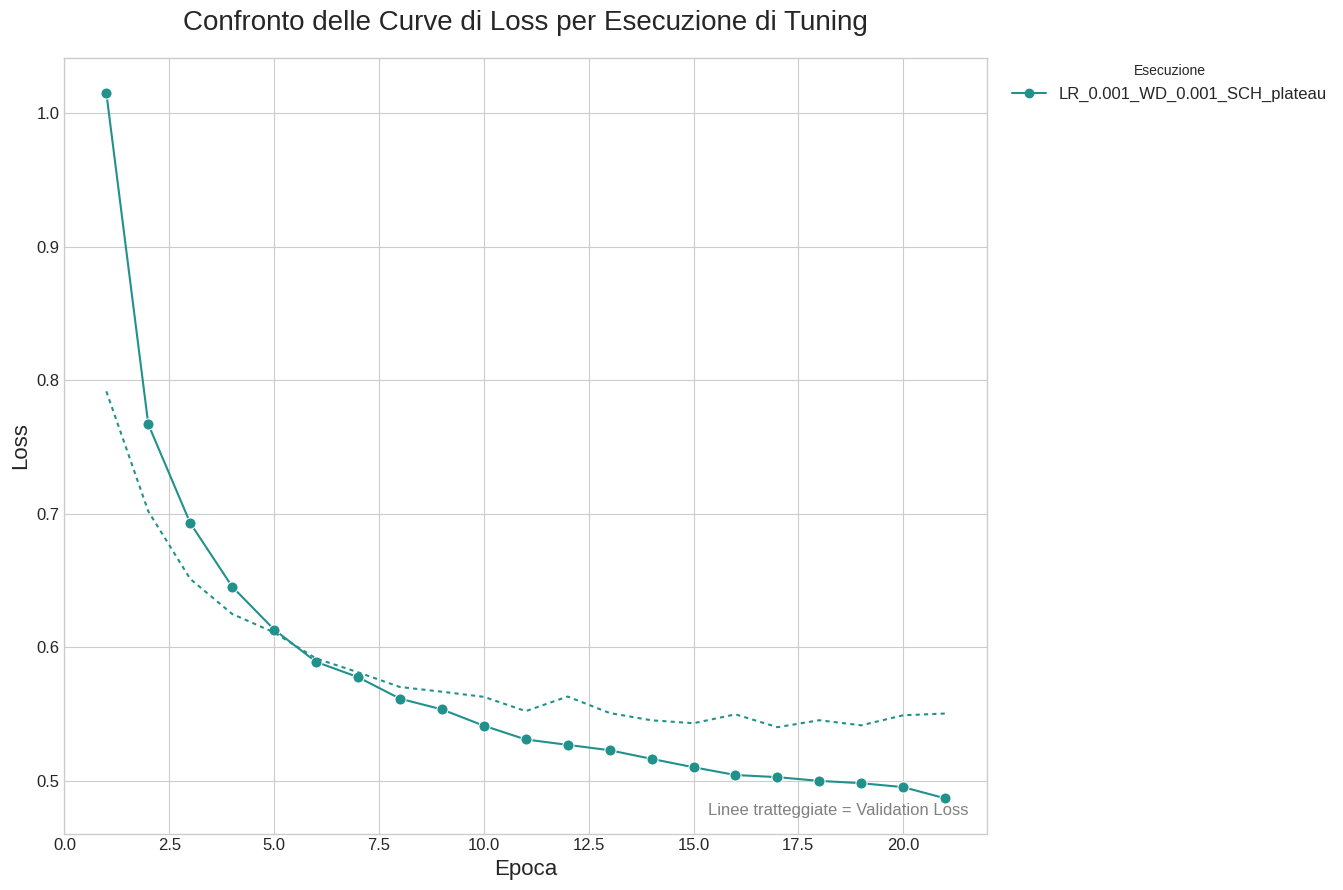

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

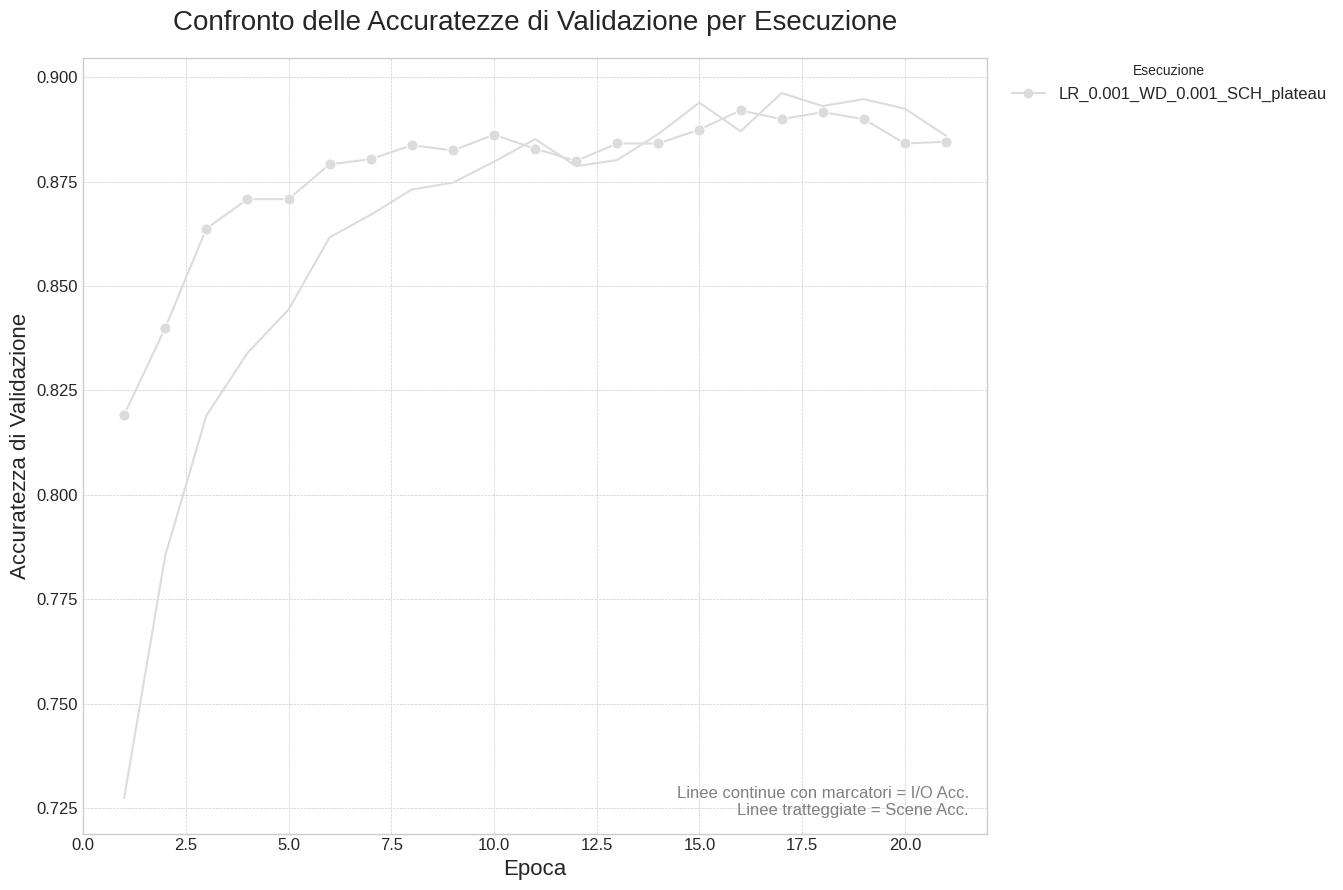

In [11]:
if 'all_histories' not in locals() or not all_histories:
    print("La variabile 'all_histories' non è stata trovata o è vuota.")
    print("Per favore, esegui prima il ciclo di hyperparameter tuning.")
else:
    # --- 1. Prepara i dati per il plotting ---
    plot_data = []
    for run_name, history in all_histories.items():
        for epoch_data in history:
            epoch_data['run_name'] = run_name
            plot_data.append(epoch_data)
            
    df_history = pd.DataFrame(plot_data)
    df_history['vl_scene_avg'] = (df_history['vl_sc1'] + df_history['vl_sc2']) / 2
    
    # Definiamo gli stili in anticipo per ogni esecuzione
    num_runs = len(df_history['run_name'].unique())
    run_names = df_history['run_name'].unique()
    
    # Palette di colori
    palette_loss = sns.color_palette("viridis", n_colors=num_runs)
    palette_acc = sns.color_palette("coolwarm", n_colors=num_runs)
    
    # Dizionari per mappare ogni esecuzione a uno stile specifico
    markers_map = {name: style for name, style in zip(run_names, ['o', 's', '^', 'P', 'D', 'X'])}


    # --- 2. Plot delle Curve di Loss ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Plottiamo separatamente training e validation loss per un controllo maggiore
    sns.lineplot(data=df_history, x='epoch', y='tr_loss', hue='run_name', 
                 style='run_name', markers=markers_map, dashes=False,
                 ax=ax1, palette=palette_loss, legend='full', markersize=8)
                 
    sns.lineplot(data=df_history, x='epoch', y='vl_loss', hue='run_name',
                 style='run_name', ax=ax1, palette=palette_loss, legend=False,
                 dashes={name: (2, 2) for name in df_history['run_name'].unique()}, markers=False)

    ax1.set_title('Confronto delle Curve di Loss per Esecuzione di Tuning', fontsize=20, pad=20)
    ax1.set_xlabel('Epoca', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.tick_params(axis='both', labelsize=12)
    ax1.legend(title='Esecuzione', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)
    
    plt.text(0.98, 0.02, 'Linee tratteggiate = Validation Loss', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax1.transAxes, color='gray', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


    # --- 3. Plot delle Curve di Accuratezza di Validazione ---
    fig, ax2 = plt.subplots(figsize=(16, 9))
    
    # Definiamo gli stili per questo grafico
    # I/O -> linea continua, Scena -> linea tratteggiata
    # Creiamo un dizionario di stili per ogni combinazione di run_name e tipo di accuratezza
    dashes_map = {}
    for run in run_names:
        dashes_map[run] = "" # Stringa vuota per linea continua (verrà gestito da seaborn)
        
    # I/O -> Linea continua
    sns.lineplot(data=df_history, x='epoch', y='vl_io', hue='run_name', 
                 style='run_name', dashes=False, markers=markers_map, 
                 ax=ax2, palette=palette_acc, markersize=8)
                 
    # Scena -> Linea tratteggiata
    sns.lineplot(data=df_history, x='epoch', y='vl_scene_avg', hue='run_name', 
                 style='run_name', dashes=True, markers=False, 
                 ax=ax2, palette=palette_acc)

    ax2.set_title('Confronto delle Accuratezze di Validazione per Esecuzione', fontsize=20, pad=20)
    ax2.set_xlabel('Epoca', fontsize=16)
    ax2.set_ylabel('Accuratezza di Validazione', fontsize=16)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Migliore gestione della legenda
    handles, labels = ax2.get_legend_handles_labels()
    unique_labels_count = df_history['run_name'].nunique()
    ax2.legend(handles[:unique_labels_count], labels[:unique_labels_count], 
               title='Esecuzione', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)

    plt.text(0.98, 0.02, 'Linee continue con marcatori = I/O Acc.\nLinee tratteggiate = Scene Acc.',
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax2.transAxes, color='gray', fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [12]:
def evaluate_sensor_subset(model, loader, battery_level, sensor_slices, active_sensors):
    model.eval()
    model.if_train = False

    # build 1×C×1 mask: 1 where channel belongs to any active sensor, else 0
    C = loader.dataset[0][0].shape[0]
    full_mask = torch.zeros(1, C, 1, device=device)
    for i in active_sensors:
        c0, c1 = sensor_slices[i]
        full_mask[:, c0:c1, :] = 1

    total = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    correct_exit = {1: 0, 2: 0, 3: 0}

    # for F1 we collect true/pred lists per exit
    y_true = {1: [], 2: [], 3: []}
    y_pred = {1: [], 2: [], 3: []}

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            feats = feats.float().to(device) * full_mask
            io_lbls = io_lbls.view(-1).to(device)
            sc_lbls = sc_lbls.view(-1).to(device)
            bsz = feats.size(0)
            batt = torch.full((bsz,), battery_level,
                              dtype=torch.float32, device=device)

            outs, exit_idx = model(feats, battery_level=batt)
            exit_idx = int(exit_idx)  # assume model returns a single exit for whole batch

            total += bsz
            exit_counts[exit_idx] += bsz

            if exit_idx == 1:
                preds = outs[0].argmax(dim=1)
                labels = io_lbls
            elif exit_idx == 2:
                preds = outs[1].argmax(dim=1)
                labels = sc_lbls
            else:
                preds = outs[2].argmax(dim=1)
                labels = sc_lbls

            # accuracy count
            correct_exit[exit_idx] += (preds == labels).sum().item()

            # accumulate for F1
            y_true[exit_idx].extend(labels.cpu().tolist())
            y_pred[exit_idx].extend(preds.cpu().tolist())

    # compute rates & accuracies
    exit_rates = {e: exit_counts[e] / total * 100 for e in exit_counts}
    accuracy_at_exit = {
        e: (correct_exit[e] / exit_counts[e] if exit_counts[e] else 0.0)
        for e in exit_counts
    }
    overall_acc = sum(correct_exit.values()) / total

    # compute F1 scores per exit (macro-average)
    f1_at_exit = {}
    for e in exit_counts:
        if exit_counts[e]:
            f1_at_exit[e] = f1_score(
                y_true[e], y_pred[e], average="macro", zero_division=0
            )
        else:
            f1_at_exit[e] = 0.0

    # overall F1: concatenate all exits
    all_true = sum((y for y in y_true.values()), [])
    all_pred = sum((y for y in y_pred.values()), [])
    overall_f1 = (
        f1_score(all_true, all_pred, average="macro", zero_division=0)
        if total else 0.0
    )

    return {
        "active_sensors": active_sensors,
        "exit_rates": exit_rates,
        "accuracy_at_exit": accuracy_at_exit,
        "overall_acc": overall_acc,
        "f1_at_exit": f1_at_exit,
        "overall_f1": overall_f1
    }

In [13]:
BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.001_WD_0.001_SCH_plateau/best_model.pth"
train_shape = train_ds[0][0].shape

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# battery_levels = np.linspace(0, 1, 11)

sensor_slices = [(0,6), (6,9), (9,12), (12,13), (13,14)]
sensors_name = ["Acc", "Mag", "Gyro", "Press", "Temp"]
keep_sensors = [0, 1, 2, 3, 4]

# keep only sensors[0] and sensors[1]
result = evaluate_sensor_subset(
    model=model,
    loader=test_loader,
    battery_level=1,
    sensor_slices=sensor_slices,
    active_sensors=keep_sensors
)

# Build list of kept sensor names
kept = [sensors_name[i] for i in keep_sensors]
print("Kept sensors:", ", ".join(kept))
print(f"Exit rates: {result['exit_rates']}")
print(f"Accuracy at exits: {result['accuracy_at_exit']}")
print(f"Overall accuracy: {result['overall_acc']:.3f}")

Kept sensors: Acc, Mag, Gyro, Press, Temp
Exit rates: {1: 1.9118869492934332, 2: 0.0, 3: 98.08811305070657}
Accuracy at exits: {1: 1.0, 2: 0.0, 3: 0.9050847457627119}
Overall accuracy: 0.907


In [16]:
import itertools
import json
import os

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.001_WD_0.001_SCH_plateau/best_model.pth"
train_shape = train_ds[0][0].shape

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# battery_levels = np.linspace(0, 1, 11)

sensor_slices = [(0,6), (6,9), (9,12), (12,13), (13,14)]
sensor_indices = [0, 1, 2, 3, 4]
sensor_names = ["Acc", "Mag", "Gyro", "Press", "Temp"]

# Generate all non-empty subsets (combinations) of sensor indices
all_combinations = [
    list(combo)
    for r in range(1, len(sensor_indices) + 1)
    for combo in itertools.combinations(sensor_indices, r)
]

# Evaluate each combination and collect results
results = []
i = 1
for combo in all_combinations:
    print(f"Iteration {i}/{len(all_combinations)} Evaluating combo: {combo}")
    # Evaluate the model on this subset
    res = evaluate_sensor_subset(
        model=model,
        loader=test_loader,
        battery_level=0.5,
        sensor_slices=sensor_slices,
        active_sensors=combo
    )
    # Map indices to names for readability
    res["active_sensor_names"] = [sensor_names[i] for i in combo]
    results.append(res)

    i += 1

# Define output filepath
output_path = "/kaggle/working/b_0.5.json"

# Save results to JSON
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved evaluation results for {len(results)} combinations")

Iteration 0/31 Evaluating combo: [0]
Iteration 1/31 Evaluating combo: [1]
Iteration 2/31 Evaluating combo: [2]
Iteration 3/31 Evaluating combo: [3]
Iteration 4/31 Evaluating combo: [4]
Iteration 5/31 Evaluating combo: [0, 1]
Iteration 6/31 Evaluating combo: [0, 2]
Iteration 7/31 Evaluating combo: [0, 3]
Iteration 8/31 Evaluating combo: [0, 4]
Iteration 9/31 Evaluating combo: [1, 2]
Iteration 10/31 Evaluating combo: [1, 3]
Iteration 11/31 Evaluating combo: [1, 4]
Iteration 12/31 Evaluating combo: [2, 3]
Iteration 13/31 Evaluating combo: [2, 4]
Iteration 14/31 Evaluating combo: [3, 4]
Iteration 15/31 Evaluating combo: [0, 1, 2]
Iteration 16/31 Evaluating combo: [0, 1, 3]
Iteration 17/31 Evaluating combo: [0, 1, 4]
Iteration 18/31 Evaluating combo: [0, 2, 3]
Iteration 19/31 Evaluating combo: [0, 2, 4]
Iteration 20/31 Evaluating combo: [0, 3, 4]
Iteration 21/31 Evaluating combo: [1, 2, 3]
Iteration 22/31 Evaluating combo: [1, 2, 4]
Iteration 23/31 Evaluating combo: [1, 3, 4]
Iteration 24/3

## Evaluating performance

In [17]:
def count_parameters(model):
    """Counts the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- How to use it in your script ---

# First, instantiate your model (you've already done this)
# Make sure to use the same parameters as in your training script
train_shape = train_ds[0][0].shape
n_io = len(train_ds.io_label_encoder.classes_)
n_scene = len(train_ds.scene_label_encoder.classes_)

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=n_io,
    n_scene=n_scene
).to(device)

# Now, call the function to get the count
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:}")

estimated_size = total_params * 4 / 1000 # FP32 precision
print(f"Estimated Size: {estimated_size:,} KB")

Total Trainable Parameters: 16234
Estimated Size: 64.936 KB


# TODO
- Data Augmentation for Time-Series Data
- attention mechanism

# TO DELETE THE /kaggle/working/ FILES

In [33]:
import shutil

directory_path = "/kaggle/working/"

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory {directory_path}")
else:
    print(f"Directory {directory_path} not found")

Deleted directory /kaggle/working/model1_eecnn
